# Demo 3: simulation-based inference (`sbi`) for parameter posterior inference

In this demo, we will implement a toy simulator and do inference on it given an observation.

See https://www.mackelab.org/sbi/ for full tutorials.

In [27]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
plt.style.use('./matplotlibrc_notebook')

In [28]:
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

### Define the toy simulator.
We make a stochastic simulator that is just adding gaussian noise with mean `mu` and variance `sigma` to the parameters, i.e.

$x \sim p(x|\theta) = \theta + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma^2)$

In [29]:
def linear_gaussian(theta):
    mu = 3.0
    sigma = 0.5
    return theta + mu + torch.randn_like(theta) * sigma

### Define prior (proposal) distribution for the simulator.

In [40]:
num_dim = 2
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

As an example, simulate from two random draws of parameter `theta` and look at their respective simulated "data", `x`. 

The question is, given an observation `x_o`, infer the most likely parameter `theta_o` that produced that observation.

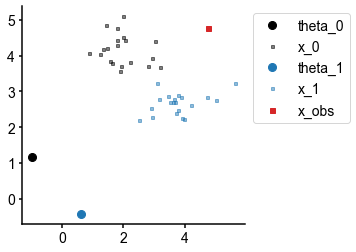

In [41]:
torch.manual_seed(42)
theta_o = prior.sample((1,))
x_o = linear_gaussian(theta_o)

num_sims = 20
for i_ in range(2):
    theta = prior.sample((1,))
    x = linear_gaussian(theta.repeat(num_sims,1))
    plt.plot(theta[:,0], theta[:,1], f'oC{i_}', label=f'theta_{i_}', ms=8)
    plt.plot(x[:,0], x[:,1], f'sC{i_}', label=f'x_{i_}', alpha=0.5)

plt.plot(x_o[:,0], x_o[:,1], f'sC4', label=f'x_obs', alpha=1, ms=5)
    
    
plt.legend(frameon=True, bbox_to_anchor=[1.5,0,0,1])

### Make the training data by simulating many times with random `theta`.

In [43]:
num_training = 2000
theta = prior.sample((num_training,))
x = linear_gaussian(theta)

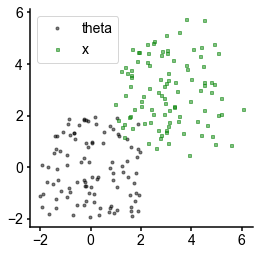

In [44]:
plt.plot(theta[:100,0], theta[:100,1], f'ok', label=f'theta', alpha=0.5)
plt.plot(x[:100,0], x[:100,1], f'sg', label=f'x', alpha=0.5)
plt.legend(frameon=True)

### Train density estimatior.

In [45]:
inference = SNPE(prior=prior)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 118 epochs.

### Get posterior distribution conditioned on `x_o` and sample.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

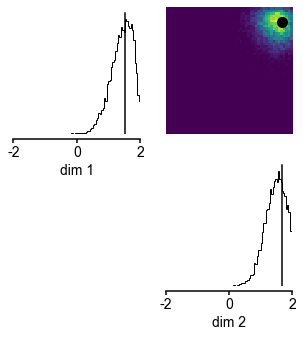

In [46]:
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((10000,), x=x_o)
# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2]], figsize=(5, 5),
    points=[theta_o], points_colors=['C0']
)

### We can also check 'predictive simulations' by simulating the posterior samples again.

In [47]:
predictive_samples = linear_gaussian(posterior_samples)

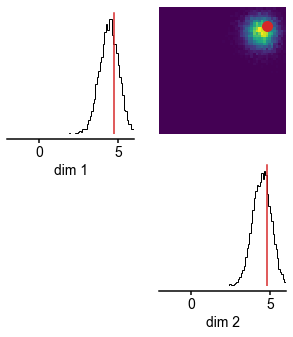

In [48]:
# plot posterior samples
_ = analysis.pairplot(
    predictive_samples, limits=[[-2, 6], [-2, 6]], figsize=(5, 5),
    points=[x_o], points_colors=['C4']
)